In [3]:
import os
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torchvision
from torchvision.datasets import FashionMNIST
from collections import OrderedDict
import torch
from clip import clip

In [4]:
descriptions = {
    'T-shirt/top': "a stylish T-shirt with a trendy design",
    'Trouser': "a pair of comfortable trousers for everyday wear",
    'Pullover': "a fashionable pullover sweater to keep you warm",
    'Dress': "a classy dress suitable for various occasions",
    'Coat': "a stylish and warm coat to keep you cozy in colder weather",
    'Sandal': "a casual sandal for a laid-back look",
    'Shirt': "a cozy shirt for a relaxed and comfortable feel",
    'Sneaker': "a comfortable and trendy sneaker, perfect for casual and sporty styles",
    'Bag': "a chic bag to complement your outfit",
    'Ankle boot': "a trendy ankle boot to complete your style"
}

In [15]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.Grayscale(3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the FashionMNIST dataset
fashionmnist = FashionMNIST(root='./data', train=False, download=True, transform=transform)

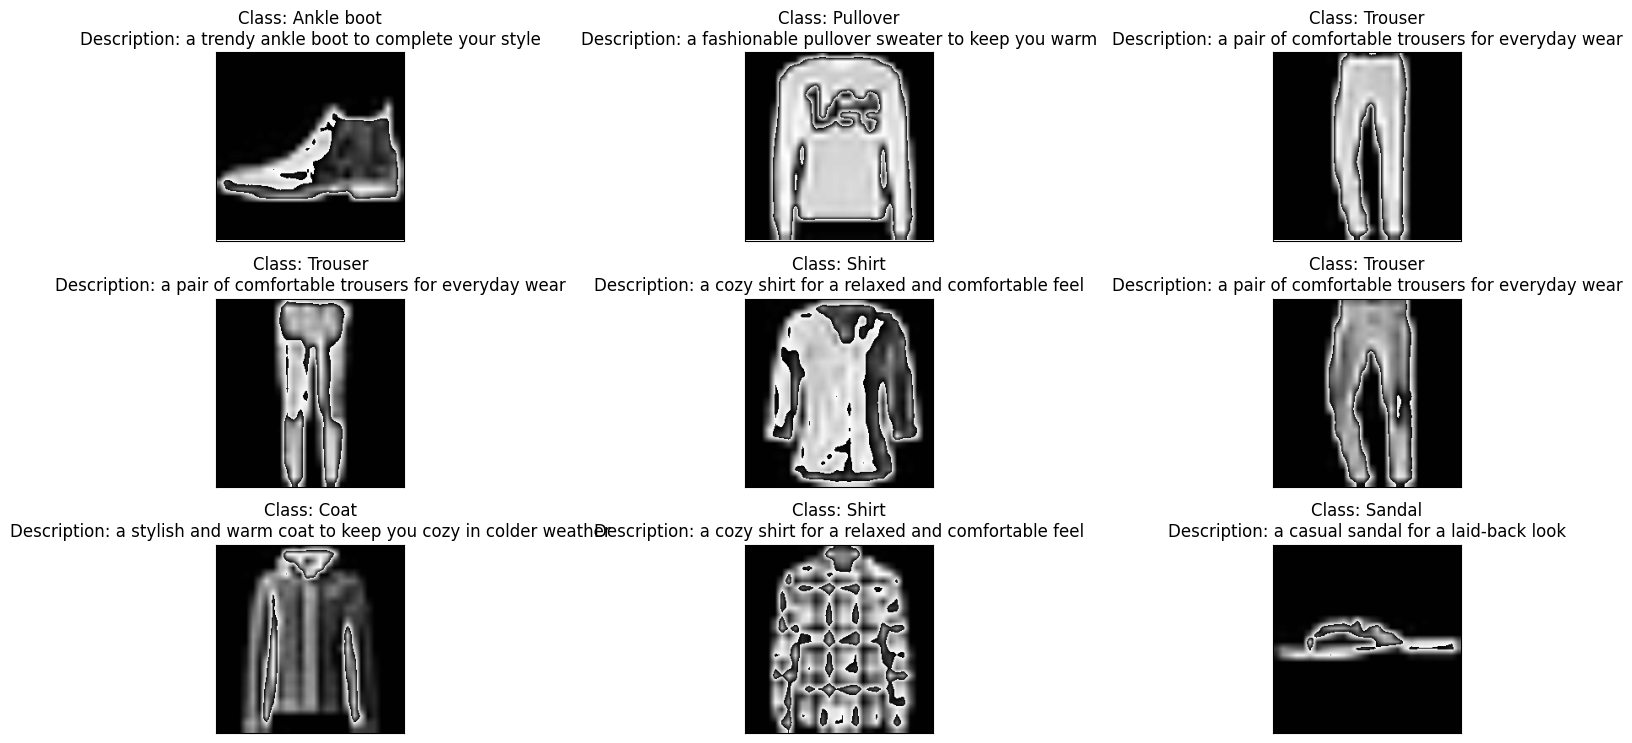

In [32]:
original_images = []
images = []
texts = []

plt.figure(figsize=(16, 10))

# Assuming you want to display the first 9 images
for i in range(9):
    image, label = fashionmnist[i]
    class_name = fashionmnist.classes[label]

    plt.subplot(4, 3, i + 1)
    plt.imshow(transforms.ToPILImage()(image))
    plt.title(f"Class: {class_name}\nDescription: {descriptions[class_name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(image)
    texts.append(descriptions[class_name])

plt.tight_layout()
plt.show()

In [17]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(name='ViT-B/16', device=device, download_root='/shareddata/clip/')

# Convert images to tensor and move to GPU
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

# Encode image and text features
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [18]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

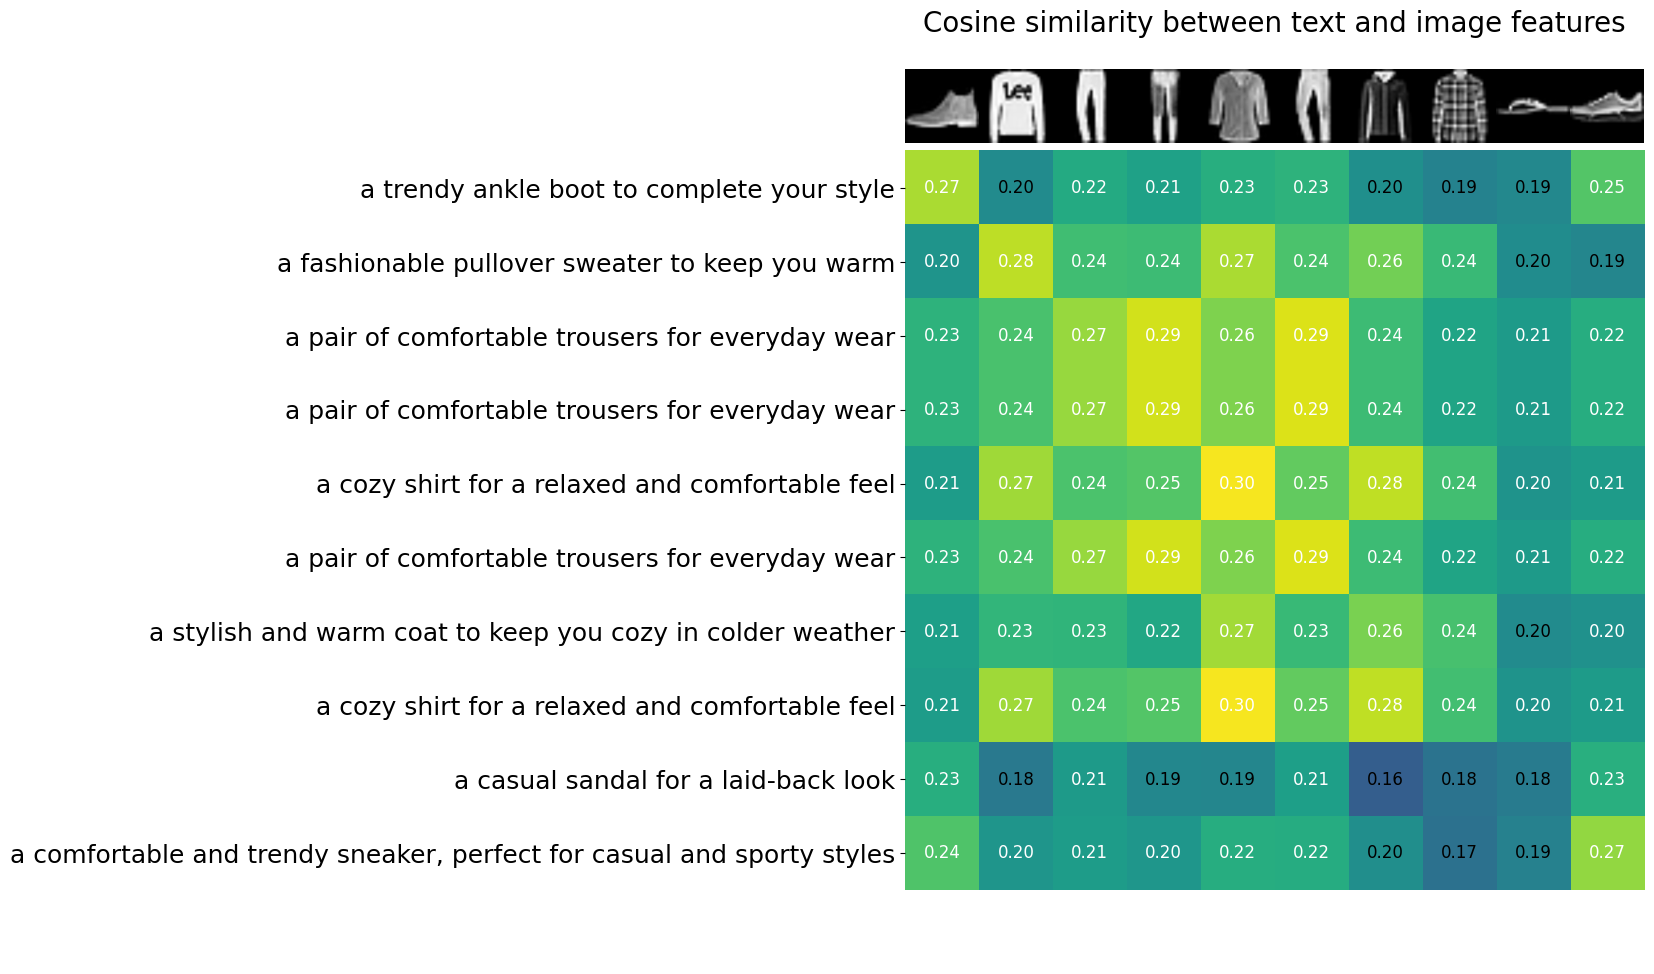

In [29]:
count = len(descriptions)
plt.figure(figsize=(18, 12))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    image_np = np.transpose(image.numpy(), (1, 2, 0))  # Convert tensor to NumPy array
    plt.imshow(image_np[:, :, 0], cmap='gray', extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        text_color = 'white' if similarity[y, x] > 0.2 else 'black'
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12, color=text_color)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)
plt.show()

In [23]:
text_descriptions = [f"This is a photo of a {label}" for label in fashionmnist.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [24]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

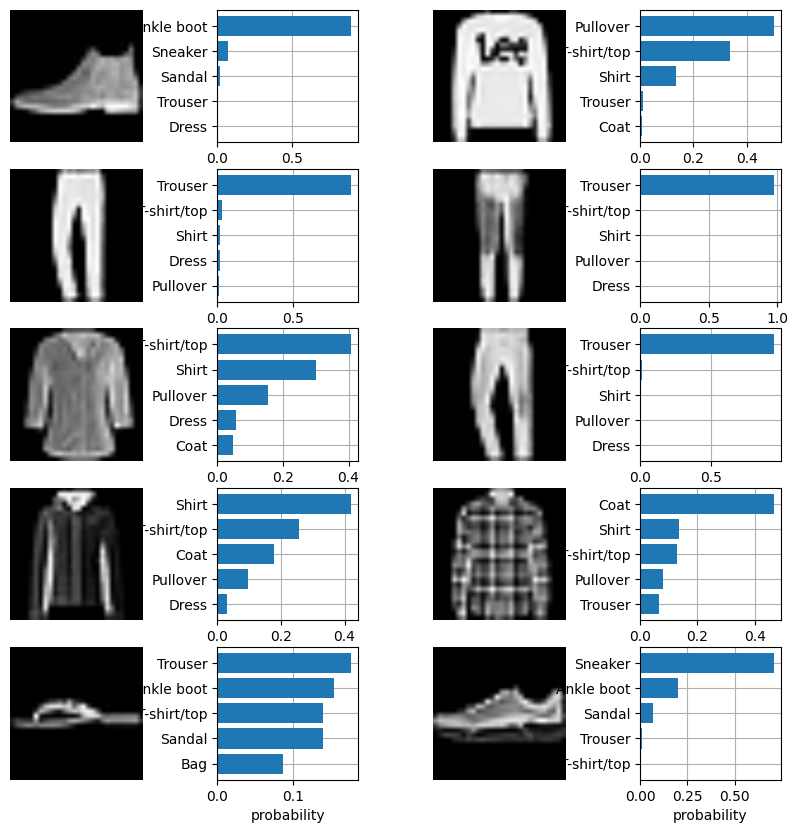

In [31]:
plt.figure(figsize=(10, 10))

for i, image in enumerate(original_images):
    plt.subplot(5, 4, 2 * i + 1)
    
    # Convert PyTorch tensor to NumPy array and transpose dimensions
    image_np = np.transpose(image.numpy(), (1, 2, 0))
    
    # Normalize pixel values to the range [0, 1]
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    
    plt.imshow(image_np)
    plt.axis("off")

    plt.subplot(5, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [fashionmnist.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()
